In [1]:
from modules.environment_manager import get_notebook_path, enforce_venv, get_persistent_config_data

NOTEBOOK_NAME = "inversion_result_analysis.ipynb"

NOTEBOOK_PATH = get_notebook_path(NOTEBOOK_NAME)
enforce_venv(NOTEBOOK_PATH)
THREADS, MEMORY, HSI_CONFIG, PROJECT_FOLDER, OUTPUT_FOLDER = get_persistent_config_data(NOTEBOOK_PATH)

In [2]:
import numpy as np
from matplotlib import  pyplot as plt

In [3]:
inverted_prosail = np.load(OUTPUT_FOLDER / "inversion_result.npy")

success = inverted_prosail[:, :, 0]
n = inverted_prosail[:, :, 1]
cab = inverted_prosail[:, :, 2]
ccx = inverted_prosail[:, :, 3]
ewt = inverted_prosail[:, :, 4]
lma = inverted_prosail[:, :, 5]
lai = inverted_prosail[:, :, 6]
psoil = inverted_prosail[:, :, 7]
sza = inverted_prosail[:, :, 8]
vza = inverted_prosail[:, :, 9]
raa = inverted_prosail[:, :, 10]

CMAP = "viridis"

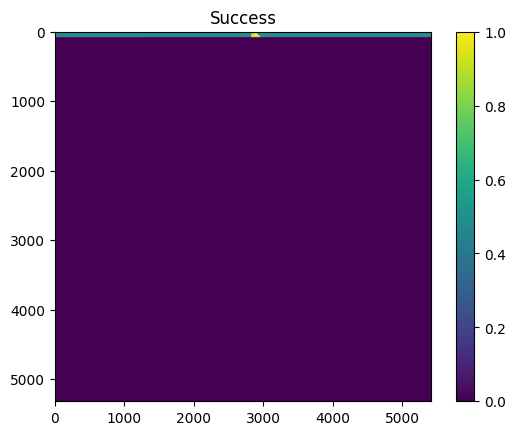

In [4]:
plt.figure()
plt.imshow(success, cmap=CMAP)
plt.colorbar()
plt.title('Success')
plt.show()

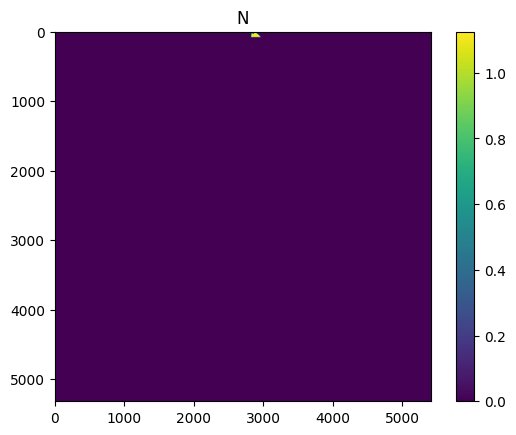

In [5]:
plt.figure()
plt.imshow(n, cmap=CMAP)
plt.colorbar()
plt.title('N')
plt.show()

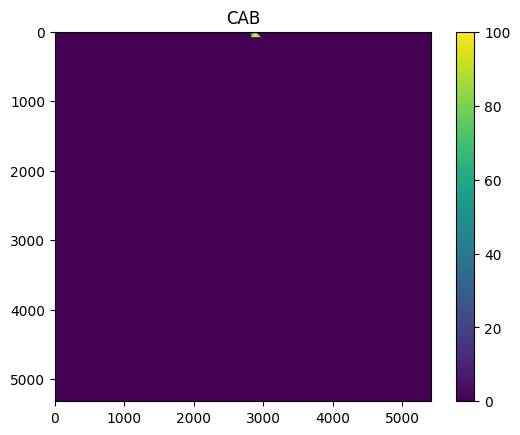

In [6]:
plt.figure()
plt.imshow(cab, cmap=CMAP)
plt.colorbar()
plt.title('CAB')
plt.show()

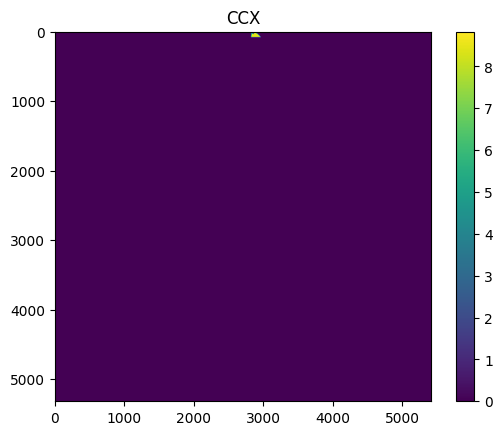

In [7]:
plt.figure()
plt.imshow(ccx, cmap=CMAP)
plt.colorbar()
plt.title('CCX')
plt.show()

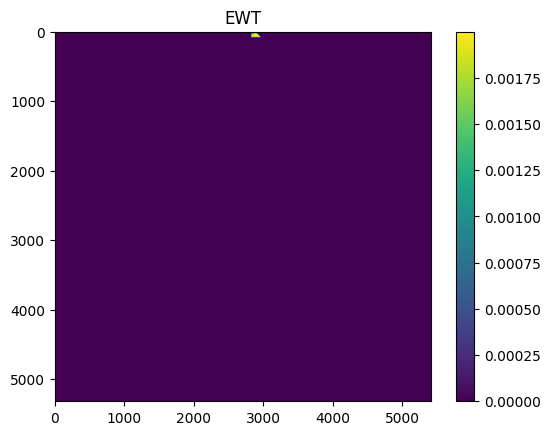

In [8]:
plt.figure()
plt.imshow(ewt, cmap=CMAP)
plt.colorbar()
plt.title('EWT')
plt.show()

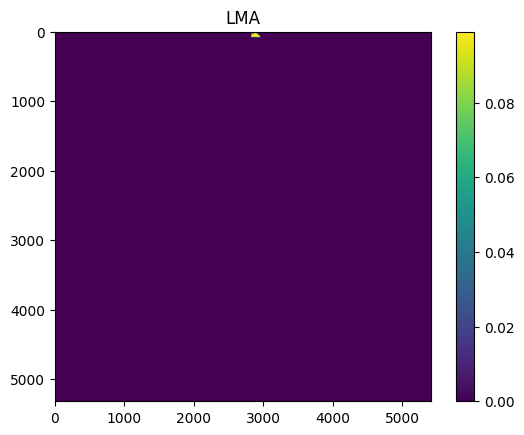

In [9]:
plt.figure()
plt.imshow(lma, cmap=CMAP)
plt.colorbar()
plt.title('LMA')
plt.show()

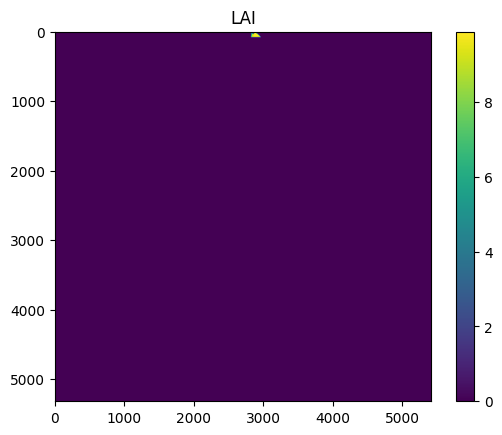

In [10]:
plt.figure()
plt.imshow(lai, cmap=CMAP)
plt.colorbar()
plt.title('LAI')
plt.show()

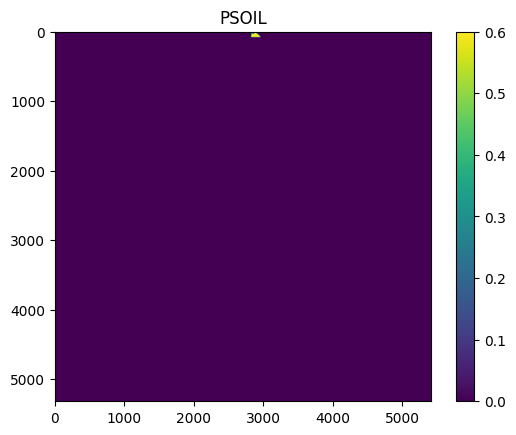

In [11]:
plt.figure()
plt.imshow(psoil, cmap=CMAP)
plt.colorbar()
plt.title('PSOIL')
plt.show()

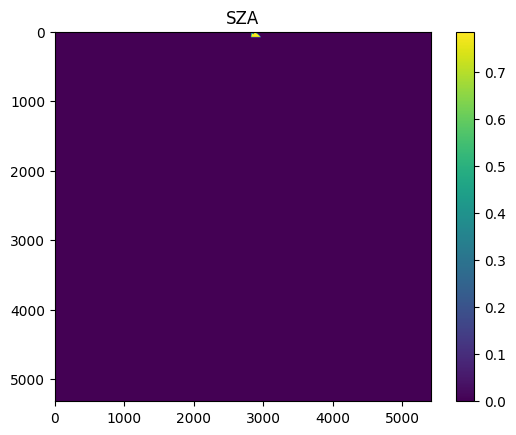

In [12]:
plt.figure()
plt.imshow(sza, cmap=CMAP)
plt.colorbar()
plt.title('SZA')
plt.show()

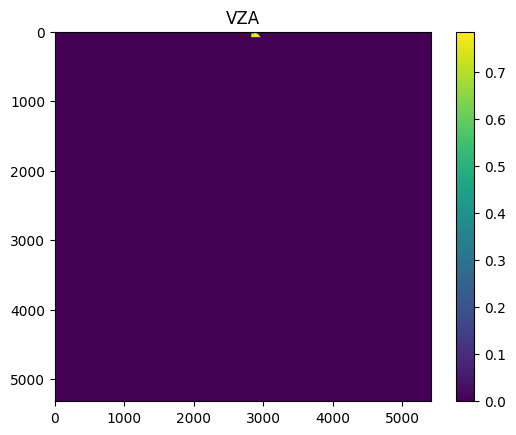

In [13]:
plt.figure()
plt.imshow(vza, cmap=CMAP)
plt.colorbar()
plt.title('VZA')
plt.show()

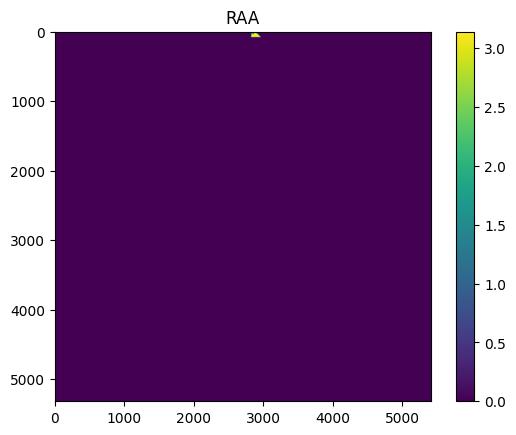

In [14]:
plt.figure()
plt.imshow(raa, cmap=CMAP)
plt.colorbar()
plt.title('RAA')
plt.show()